# To Eat, or Not to Eat?
## Part 2: Building models to predict whether mushrooms are edible or poisonous
### Sakshi and Abbie
### March 9, 2022

### Introduction

This notebook is a continuation of our mushroom project. The first notebook detailed an exploratory analysis to provide an overall understanding of variable types and variable distributions. Now that we better understand our data, we can commence pre-processing and model-building.

As a reminder, this data was retrieved from the UCI Machine Learning repository. It details several characteristics about mushrooms and also classifies them by whether they are edible or poisonous. The data draws from The Audubon Society Field Guide to North American Mushrooms, published in 1981. 

The goal of this project is to construct a model with high accuracy and recall, which can predict whether a mushroom is edible or poisonous.

**Libraries and Data Set Required for Notebook**

In [165]:
# load initial libraries

# The basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# For pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# For models and performance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [17]:
# Read in the 1987 original data set
mushroom = pd.read_csv('1987_data.csv')

# View the first few rows
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Pre-processing

Fortunately, this data set is fairly clean and requires very minimal pre-processing. No resampling is needed, as the classes are fairly equally distributed. Only one variable ("stalk-root") contains missing variables. All variables are categorical, meaning we can apply the same label encoding technique on all of them.

*Our pre-processing steps:*
1. Remove the "stalk-root" variable (too many are missing to be useful for analysis)
2. Convert all variables to numerical (necessary for machine learning algorithms) 
3. Conduct correlation matrix to determine import features
4. Implement appropriate feature engineering
5. Standardize variables

**Step 1: Handle Nulls**

Remove the stalk-root variable

In [2]:
# Drop the stalk root var
mushroom_df = mushroom.drop('stalk-root', axis=1)
mushroom_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


**Step 2: Convert to Numerical**

In [3]:
# Function to label encode data set
def label_encode(df):
    # necessary import
    from sklearn.preprocessing import LabelEncoder
    # Instantiate the label encoder
    le = LabelEncoder()
    # Create deep copy
    df_new = df.copy()
    # create columns list
    col_list = df_new.columns
    # Iterate through str columns
    for var in col_list:
        if df_new[var].dtypes == 'O':
            # Complete transformation
            df_new[var] = le.fit_transform(df_new[var])
    # return new data frame
    return df_new

In [4]:
# Use function on data frame
mushroom_num = label_encode(mushroom_df)
# View data frame
mushroom_num.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


**Step 3. Determine Important Features**

Before conducting the correlation matrix, we will view the distribution (between edible and poisonous), among all features in the data set. This can help us quickly visualize whether a variable could be meaningful in predicting whether a mushroom is safe to eat.

In [5]:
# Define function to display distributions among edible vs. poisonous
def violin(df, dependent_var):
    # Load necessary libraries
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    # unpivot the df from wide to long with pd.melt
    long_df = pd.melt(df, dependent_var, var_name='Characteristics')
    # set up axes
    fig, ax = plt.subplots(figsize=(20,8))
    # create violin plot
    sns.violinplot(x='Characteristics', y='value', hue='class', split = True, data=long_df, palette = 'prism')
    # drop the dependent variable
    features = df.drop([dependent_var],axis = 1)
    # Edit lables
    ax.set_xticklabels(rotation = 90, labels = list(features.columns), size=12)
    # Display plot
    plt.show()

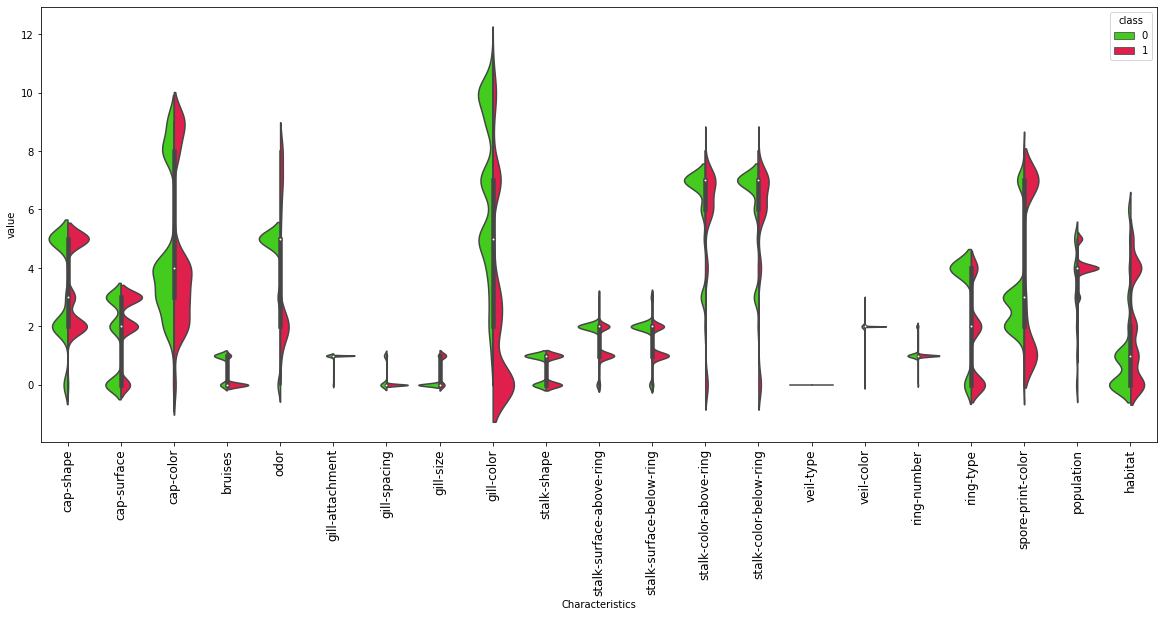

In [6]:
# Use function on data frame
violin(mushroom_num, 'class')

In the above plot, 0 represents "Edible" and 1 represents "Poisonous." 

The following variables seems to have a fairly similar distribution across classes:
* cap-shape
* cap-surface
* cap-color
* gill-attachment
* stalk shape
* veil-type
* veil-color
* ring-number

Therefore, these variables will likely not be very useful in predicting whether a mushroom is poisonous or not. We can, thus, remove them from our data set before computing the correlation matrix.

In [7]:
mushroom_num2 = mushroom_num.drop(['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'stalk-shape',
                                  'veil-type', 'veil-color', 'ring-number'], axis=1)
mushroom_num2.head()

,class,bruises,odor,gill-spacing,gill-size,gill-color,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-type,spore-print-color,population,habitat
0,1,1,6,0,1,4,2,2,7,7,4,2,3,5
1,0,1,0,0,0,4,2,2,7,7,4,3,2,1
2,0,1,3,0,0,5,2,2,7,7,4,3,2,3
3,1,1,6,0,1,5,2,2,7,7,4,2,3,5
4,0,0,5,1,0,4,2,2,7,7,0,3,0,1


In [8]:
# create function to restructure dataframe in a way that works with triangular correlation matrix
def tri_corr_matrix(df):
    # import libraries
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    
    # absolute value so that color corresponds to magnitude of correlation, regardless of direction
    df_corr = abs(df.corr())
    
    # Reading code line from inside out...
        # Get shape of matrix
        # Use np.ones to replace all values with ones in the same shape as matrix
        # Wrap inside np.triu, in order to create an upper triangle of matrix
                # Upper diagonal of matrix are now 1s and lower diagonal of matrix are zeros
        # Create boolean where 1s are 'true' and 0s are 'false' (this is needed for mask function in next step)
        # mask the resulting array to be the same shape/type as the original df
                # We are only maintaining the values, where the boolean would be 'false'
    df_corr_tri = df_corr.mask(np.triu(np.ones(df_corr.shape)).astype(np.bool))
    # round values for easier reading
    df_corr_tri = df_corr_tri.round(2)
    # drop first row and last column because those will always be NaNs
    df_final = df_corr_tri.iloc[1::, :-1]
    # return df
    return df_final

In [9]:
# Implement function
mush_matrix = tri_corr_matrix(mushroom_num2)
mush_matrix

,class,bruises,odor,gill-spacing,gill-size,gill-color,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-type,spore-print-color,population
bruises,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odor,0.09,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gill-spacing,0.35,0.30,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gill-size,0.54,0.37,0.31,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gill-color,0.53,0.53,0.13,0.10,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stalk-surface-above-ring,0.33,0.46,0.12,0.21,0.06,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stalk-surface-below-ring,0.30,0.46,0.06,0.21,0.01,0.26,0.44,NaN,NaN,NaN,NaN,NaN,NaN
stalk-color-above-ring,0.15,0.08,0.17,0.27,0.30,0.06,0.13,0.11,NaN,NaN,NaN,NaN,NaN
stalk-color-below-ring,0.15,0.09,0.17,0.25,0.28,0.07,0.14,0.11,0.49,NaN,NaN,NaN,NaN
ring-type,0.41,0.69,0.28,0.20,0.46,0.63,0.39,0.39,0.05,0.03,NaN,NaN,NaN


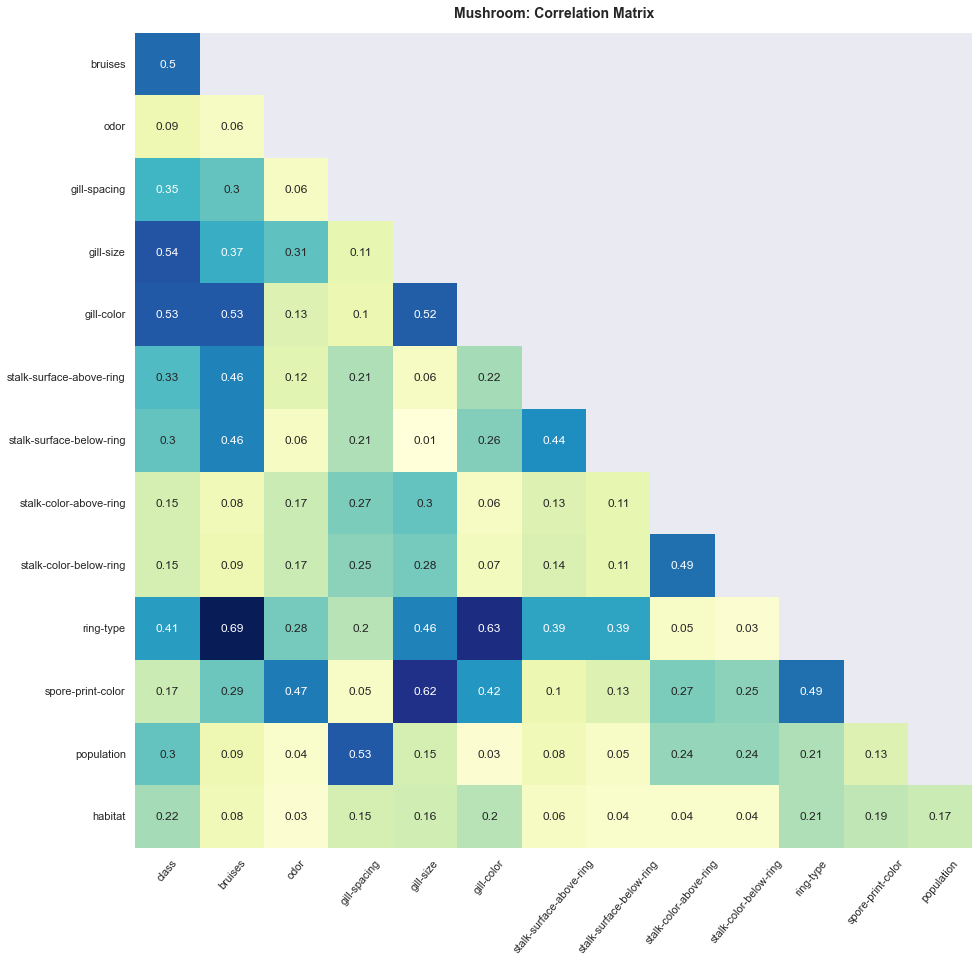

In [10]:
# Visualize matrix

# Set Figure Size
sns.set(rc={'figure.figsize':(15,15)})

# Visually display the matrix from above
# use the yellow-green-blue color map so that high correlations are more easily identifiable
h = sns.heatmap(mush_matrix, annot=True, cmap="YlGnBu", cbar=False)

# Add plot title 
h.set_title('Mushroom: Correlation Matrix', size=14, weight='bold', pad=15)

# rotate tick marks so they are easier to read
plt.xticks(rotation=50)

# Display plot
plt.show()

**Step 4: Feature Engineering**

There are not any features that have a very high correlation with class. However, "bruises," "gill-size," and "gill-color" all have correlations above 50%. We will commence the analysis with only those variables.

In [43]:
# Create refined data set with only those variables
mushroom_final = mushroom_num2[['bruises', 'gill-size', 'gill-color', 'ring-type', 'class']]
mushroom_final.head()

,bruises,gill-size,gill-color,ring-type,class
0,1,1,4,4,1
1,1,0,4,4,0
2,1,0,5,4,0
3,1,1,5,4,1
4,0,0,4,0,0


**Step 5: Standardize Variables**

Standardize variables and split into training vs. testing

In [258]:
# Get our predicted variables
X = mushroom_final.drop('class', axis=1)
# Get our outcome variable
y = mushroom_final['class']

# Split our data into training vs. testing
# We want to compute the model on our training data to train the model
# We then use that model on our testing data set to see the performance
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state=33, stratify=y)

# Standardize our data
sc=StandardScaler()
# Standardize training values
X_train = sc.fit_transform(X_train)
# Standardize testing values
X_test=sc.fit_transform(X_test)

## Compute Models

### Model 1: Logistic Regression

In [261]:
# Compute the logistic regression
logreg_model = LogisticRegression(random_state=33).fit(X_train, y_train)

# Find the predicted values (predict edible or poisonous)
y_predicted = logreg_model.predict(X_test)

# See a classification report so that we know how well we did at predicting diabetes
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1263
           1       0.82      0.77      0.79      1175

    accuracy                           0.81      2438
   macro avg       0.81      0.80      0.81      2438
weighted avg       0.81      0.81      0.81      2438



**Tune Model**

Currently, the logistic regression model is set to a default threshold of 0.5. This means that any mushroom with a predicted probability above 0.5 will be classified as 1=poisonous, while everything below 0.5 will be classified as 0=edible. To boost our recall score above 80%, we can amend the decision threshold. Doing so, could increase the number of mushrooms predicted as "poisonous," which would be very beneficial to us.

First, we can calculate the predicted probabilities in our sample

In [262]:
# gain the predicted probailities
# probability of mushroom being predicted as "poisonous" (>0.5) or "edible" (<0.5)
y_pred_prob = logreg_model.predict_proba(X_test)[::,1]
print(y_pred_prob)

[0.95612676 0.32673336 0.06285324 ... 0.02717063 0.95612676 0.38005884]


Next, we can calculate the false positive rate (fpr) and the true positive rate (tpr) at every possible decision threshold. We will use this to plot a receiver operating characteristic (roc) curve. The value at which tpr is highest and fpr is lowest is the value we will use as our new threshold.

In [263]:
# fpr = false positive rate; tpr = true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

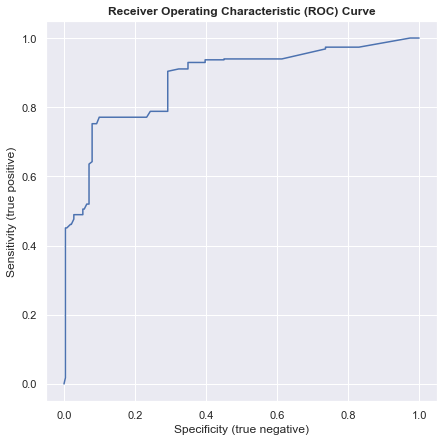

In [264]:
# Plot our ROC curve

# Set Figure Size
sns.set(rc={'figure.figsize':(7,7)})
# Plot false positive rate against true positive rate
plt.plot(fpr, tpr)
# Set labels
plt.ylabel('Sensitivity (true positive)')
plt.xlabel('Specificity (true negative)')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
# Show plot
plt.show()

In [265]:
# Find the AUC
auc = metrics.roc_auc_score(y_test, y_pred_prob)

# Display result
print(f'Area Under the Curve (AUC): {round(auc*100,2)}%')

Area Under the Curve (AUC): 87.87%


Our AUC value is fairly high and indicates that our model is definitely better at predicting whether a mushrom is poisonous, than if just left to random change.

Moreover, from examining the ROC curve, it appears that the best threshold to optimize recall would be approximately 0.36. We will amend the decision threshold accordingly, altering our predicted probabilities. 

In [266]:
# Wherever the predicted probaility is above 0.36, change the predicted value to 1, else it is 0
y_pred_tuned = np.where(y_pred_prob > 0.36, 1, 0)

# Print the classification report of the tuned predicted values to compare recall
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1263
           1       0.74      0.90      0.82      1175

    accuracy                           0.80      2438
   macro avg       0.81      0.81      0.80      2438
weighted avg       0.82      0.80      0.80      2438



Now, the recall is very high (90%). Unfortunatley, the precision has greatly suffered lowering from 82 to 74%. The overall accuracy is approximately the same (80%) as the original model.

We can now try a different technique. Despite the sample sizes already being fairly equal, we can still experiment to see if SMOTE-ENN improves the overall performance of our model.

In [273]:
# Instantiate the classifier
sm = SMOTEENN(random_state=33, sampling_strategy='not majority', n_jobs=-1)

# Resample our data
X_res, y_res = sm.fit_resample(X_train, y_train)

# Compute the logistic regression
logreg_model_res = LogisticRegression(random_state=33).fit(X_res, y_res)

# Find the predicted values (predict edible or poisonous)
y_predicted_res = logreg_model_res.predict(X_test)

# Add our amended decision threshold from above
y_pred_tuned_res = np.where(y_predicted_res > 0.36, 1, 0)

# Print the classification report of the tuned predicted values to compare recall
print(classification_report(y_test, y_pred_tuned_res))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1263
           1       0.83      0.79      0.81      1175

    accuracy                           0.82      2438
   macro avg       0.82      0.82      0.82      2438
weighted avg       0.82      0.82      0.82      2438



If we apply the resampling technique, our precision *does* increase to 83%, which is much better than without. However, our recall is now lowered to 79%, which is okay, but not quite where we want it to be. The overall accuracy is the best so far (by only a slight margin) at 82%.

**More Tuning**

In [274]:
# create a dictionary of possible parameters to iterate through
param_dict = {"penalty": ['l1', 'l2', 'elasticnet', 'none'],
             "dual": [True, False],
             "fit_intercept": [True, False],
             "class_weight": ['balanced', None],
             "random_state": [33],
             "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             "multi_class": ['auto', 'ovr', 'multinomial'],
             "warm_start": [True, False]}

# instantiate the classifier
log = LogisticRegression()

In [280]:
# Run the decision tree model through the search, using the specified parameters and 10 crossfold validation
grid_log = GridSearchCV(log, 
                      param_grid = param_dict, 
                      cv=20,
                      scoring =['recall', 'precision'],
                      refit='recall')

# Fit the search to our training data
grid_log.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(grid_log.best_params_))
print("Best logistic regression score is {}".format(grid_log.best_score_))

Tuned Logistic Regression Parameters: {'class_weight': 'balanced', 'dual': True, 'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'random_state': 33, 'solver': 'liblinear', 'warm_start': True}
Best logistic regression score is 0.7697820797630381


In [284]:
log = LogisticRegression(class_weight='balanced', dual=True, solver='liblinear', warm_start=True, random_state=33)

# Compute the logistic regression
logreg_model = log.fit(X_res, y_res)

# Find the predicted values (predict edible or poisonous)
y_predicted_res = logreg_model.predict(X_test)

# See a classification report so that we know how well we did at predicting diabetes
print(classification_report(y_test, y_predicted_res))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1263
           1       0.87      0.77      0.82      1175

    accuracy                           0.83      2438
   macro avg       0.84      0.83      0.83      2438
weighted avg       0.84      0.83      0.83      2438



## Model 2: Decision Tree

In [244]:
# Create the decision tree classifier
tree = DecisionTreeClassifier(random_state=33)
# Create our model by fitting the classifier to our data
tree_model = tree.fit(X_train, y_train)
# Find predicted values
y_pred_tree = tree_model.predict(X_test)
# Print the classification report
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1263
           1       0.95      0.93      0.94      1175

    accuracy                           0.94      2438
   macro avg       0.94      0.94      0.94      2438
weighted avg       0.94      0.94      0.94      2438



Without any tuning at all, the above decision tree already does a fabulous job of predicting whether a mushroom is edible or poisonous. We can tune below to see if it's possible to get these metrics even higher.

**Tune Model**

In [229]:
# create a dictionary of possible parameters to iterate through
param_dict = {"criterion": ["gini", "entropy"],
             "splitter": ['best', 'random'],
             "max_depth": [None, range(1,50)],
             "max_features":[None, range(1,5)],
             "max_leaf_nodes":[None, range(1,50)],
             "min_impurity_decrease":[0.0, 0.05, 0.1],
             "random_state":[33]}

# instantiate the classifier
trees = DecisionTreeClassifier()

In [230]:
# Run the decision tree model through the search, using the specified parameters and 10 crossfold validation
grid = GridSearchCV(trees, 
                      param_grid = param_dict, 
                      cv=20,
                      scoring ='recall',
                      refit='recall',
                      n_jobs = -1)

# Fit the search to our training data
grid.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid.best_params_))
print("Best decision tree score is {}".format(grid.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'random_state': 33, 'splitter': 'best'}
Best decision tree score is 0.9288559187559503


While testing for a wide range of decision tree parameters, it appears that the best parameters are the default values. of the decision tree classifier. Since this is the same as our original decision tree model and because the model already has very high performance, we will not make any further changes to this model.

In [235]:
# Gives us the weights of the importance of each predictor (the feature importance)
print(tree_model.feature_importances_, X.columns)

[0.00447148 0.09031253 0.53343818 0.3717778 ] Index(['bruises', 'gill-size', 'gill-color', 'ring-type'], dtype='object')


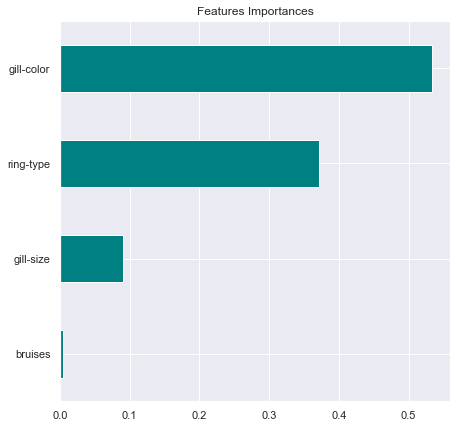

In [236]:
# Visualize which features are the most important 

# Create pandas series
importances = pd.Series(data=tree_model.feature_importances_,
                        index= X.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='teal')
plt.title('Features Importances')
plt.show()

## Model 3: KNN

In [ ]:
# code for KNN

**Tune Model**

## Model 4: Random Forest

In [233]:
# code for Random Forest


**Tune Model**

## Final Thoughts and Conclusions

**Which model was the best?**

**How we determined which model is the best.**

**How we tested for over/under fitting**